In [1]:
!nvidia-smi

/bin/bash: /home/parlange/anaconda3/envs/gigalens/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Mar 12 03:06:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
| 53%   44C    P8              50W / 390W |     10MiB / 24576MiB |      0%      Default |
|                               

This notebook may take quite a bit longer than the quickstart notebook. We set $n_{max}=8$ for the shapelets because this is the minimal number needed to capture the spiral arms features on the source galaxy, resulting in slower modeling. This is in part due to the higher memory pressure associated with a large number of shapelets components.

In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic, shapelets
from gigalens.tf.profiles.mass import epl, shear, sis
import gigalens
sns.set_style("whitegrid")
tfd = tfp.distributions

2024-03-12 03:07:00.138017: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 03:07:00.159242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 03:07:00.159261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 03:07:00.159920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 03:07:00.163902: I tensorflow/core/platform/cpu_feature_guar

2024-03-12 03:07:01.146640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-03-12 03:07:01.146980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6
2024-03-12 03:07:01.388950: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/tmp/ipykernel_1563953/3805253257.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  

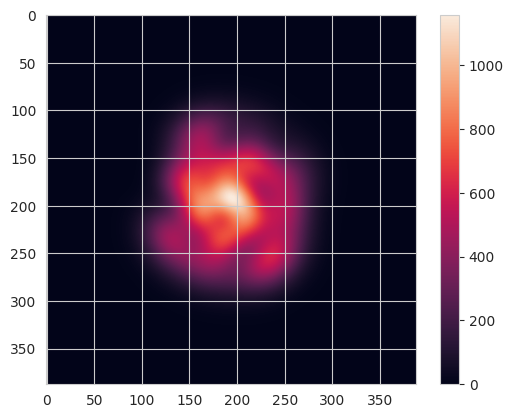

In [3]:
import gigalens
root = gigalens.__path__[0]
img = plt.imread('/home/parlange/gigalens/src/gigalens/assets/M101.jpeg')
# img = plt.imread(f'{root}/assets/spiral.jpeg')
img = img[:,131:-131]
img = np.sqrt(img[...,1].astype(np.float32))
img -= np.median(img[:20,:20])
img *= 100
from skimage.transform import downscale_local_mean
img = downscale_local_mean(img, (5,5))
img = np.pad(img, [(100, 100), (100, 100)], mode='constant')
grid = np.linspace(-1,1,len(img)).astype(np.float32)
xx,yy = np.meshgrid(grid,grid)
xx, yy = xx[np.newaxis,...,np.newaxis], yy[np.newaxis,...,np.newaxis]
n_max = 8
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=True)
components = np.squeeze(shp.light(xx, yy, beta=0.13, center_x=0, center_y=0))
X = components.reshape((shp.depth, -1))
Y = img.flatten()
sol, resid, _, _ = np.linalg.lstsq(X.T, Y)
plt.imshow((sol@X).reshape(img.shape))
plt.colorbar()

In [4]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.0), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.025),
                center_y=tfd.Normal(0, 0.025),
            )
        ),
    ]
)

amp_prior = {key: tfd.Normal(0,500/float(np.sqrt(i+1))) for i, key in enumerate(shapelets.Shapelets(n_max)._amp_names)}
source_light_params = dict(
    beta=tfd.LogNormal(tf.math.log(0.1), 0.15),
    center_x=tfd.Normal(0, 0.01),
    center_y=tfd.Normal(0, 0.01)
)

source_light_prior = tfd.JointDistributionSequential([tfd.JointDistributionNamed(source_light_params)])

prior = tfd.JointDistributionSequential(
    [lens_prior, source_light_prior]
)

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [5]:
tf.random.set_seed(121)
truth = prior.sample(1)
truth[1][0] = {**truth[1][0], 
               **{f'amp{str(i).zfill(3)}': tf.convert_to_tensor([sol[i]]) for i in range(shp.depth)}, 
               'beta': tf.convert_to_tensor([0.08], dtype=tf.float32),
              }

In [6]:
import gigalens
root = '/home/parlange/gigalens/src/gigalens/assets/'
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=1)
phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=False, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = lens_sim.simulate(truth)
err_map = np.sqrt(0.1**2 + np.clip(observed_img, 0, np.inf)/200)
np.random.seed(1)
observed_img += np.random.normal(scale=err_map)

phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=True, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = BackwardProbModel(prior, observed_img, background_rms=0.1, exp_time=200)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

2024-03-12 03:07:04.108260: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x529ad10


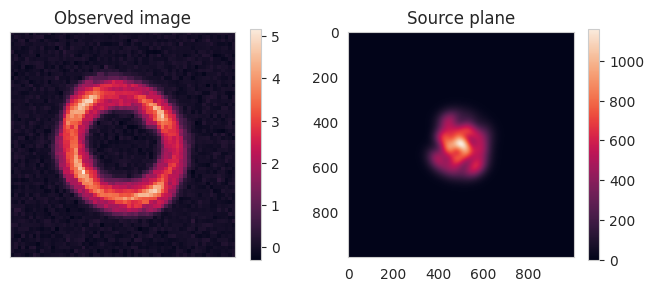

In [7]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(observed_img)
plt.title('Observed image')
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.subplot(122)
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **truth[1][0])
plt.imshow(np.squeeze(ret))
plt.title('Source plane')
plt.grid(False)
plt.colorbar()

Begin fitting.

In [8]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

See $\S2.3$: Maximum a Posteriori Estimate

In [9]:
n_map = 100
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, n_map, 1e-2/10)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=n_map, num_steps=150, seed=0)

  0%|          | 0/150 [00:00<?, ?it/s]

2024-03-12 03:07:09.478247: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f14980629d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 03:07:09.478266: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-12 03:07:09.478269: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-12 03:07:09.480911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-12 03:07:09.505777: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1710234429.543712 1564081 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
# Simulator to evaluate the log likelihood of 100 candidate solutions
lens_sim_100 = LensSimulator(phys_model, sim_config, bs=n_map)
lps = prob_model.log_prob(lens_sim_100, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

See $\S2.4$: Variational Inference

In [11]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 100, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=350)

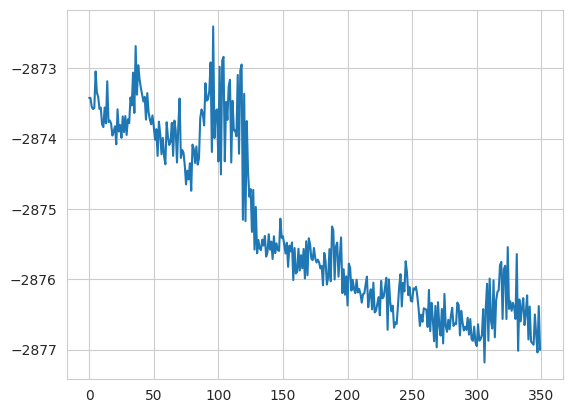

In [12]:
plt.plot(losses)

See $\S2.5$: Hamiltonian Monte Carlo

In [13]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/home/parlange/anaconda3/envs/gigalens/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [14]:
Rhat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, prob_model.bij.forward(samples))
ESS = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), prob_model.bij.forward(samples))
print('Rhat', Rhat)
print('ESS', ESS)

Rhat [[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=1.0002255>, 'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=1.0011803>, 'e2': <tf.Tensor: shape=(), dtype=float32, numpy=1.0008646>, 'e1': <tf.Tensor: shape=(), dtype=float32, numpy=1.0007194>, 'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=0.9999103>, 'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0006843>}], [{'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=1.0005833>, 'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0003047>, 'beta': <tf.Tensor: shape=(), dtype=float32, numpy=1.0008975>}]]
ESS [[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=33901.32>, 'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=17897.568>, 'e2': <tf.Tensor: shape=(), dtype=float32, numpy=19788.13>, 'e1': <tf.Tensor: shape=(), dtype=float32, numpy=28558.246>, 'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=29928.309>, 'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=27968.914>}], [{'center_

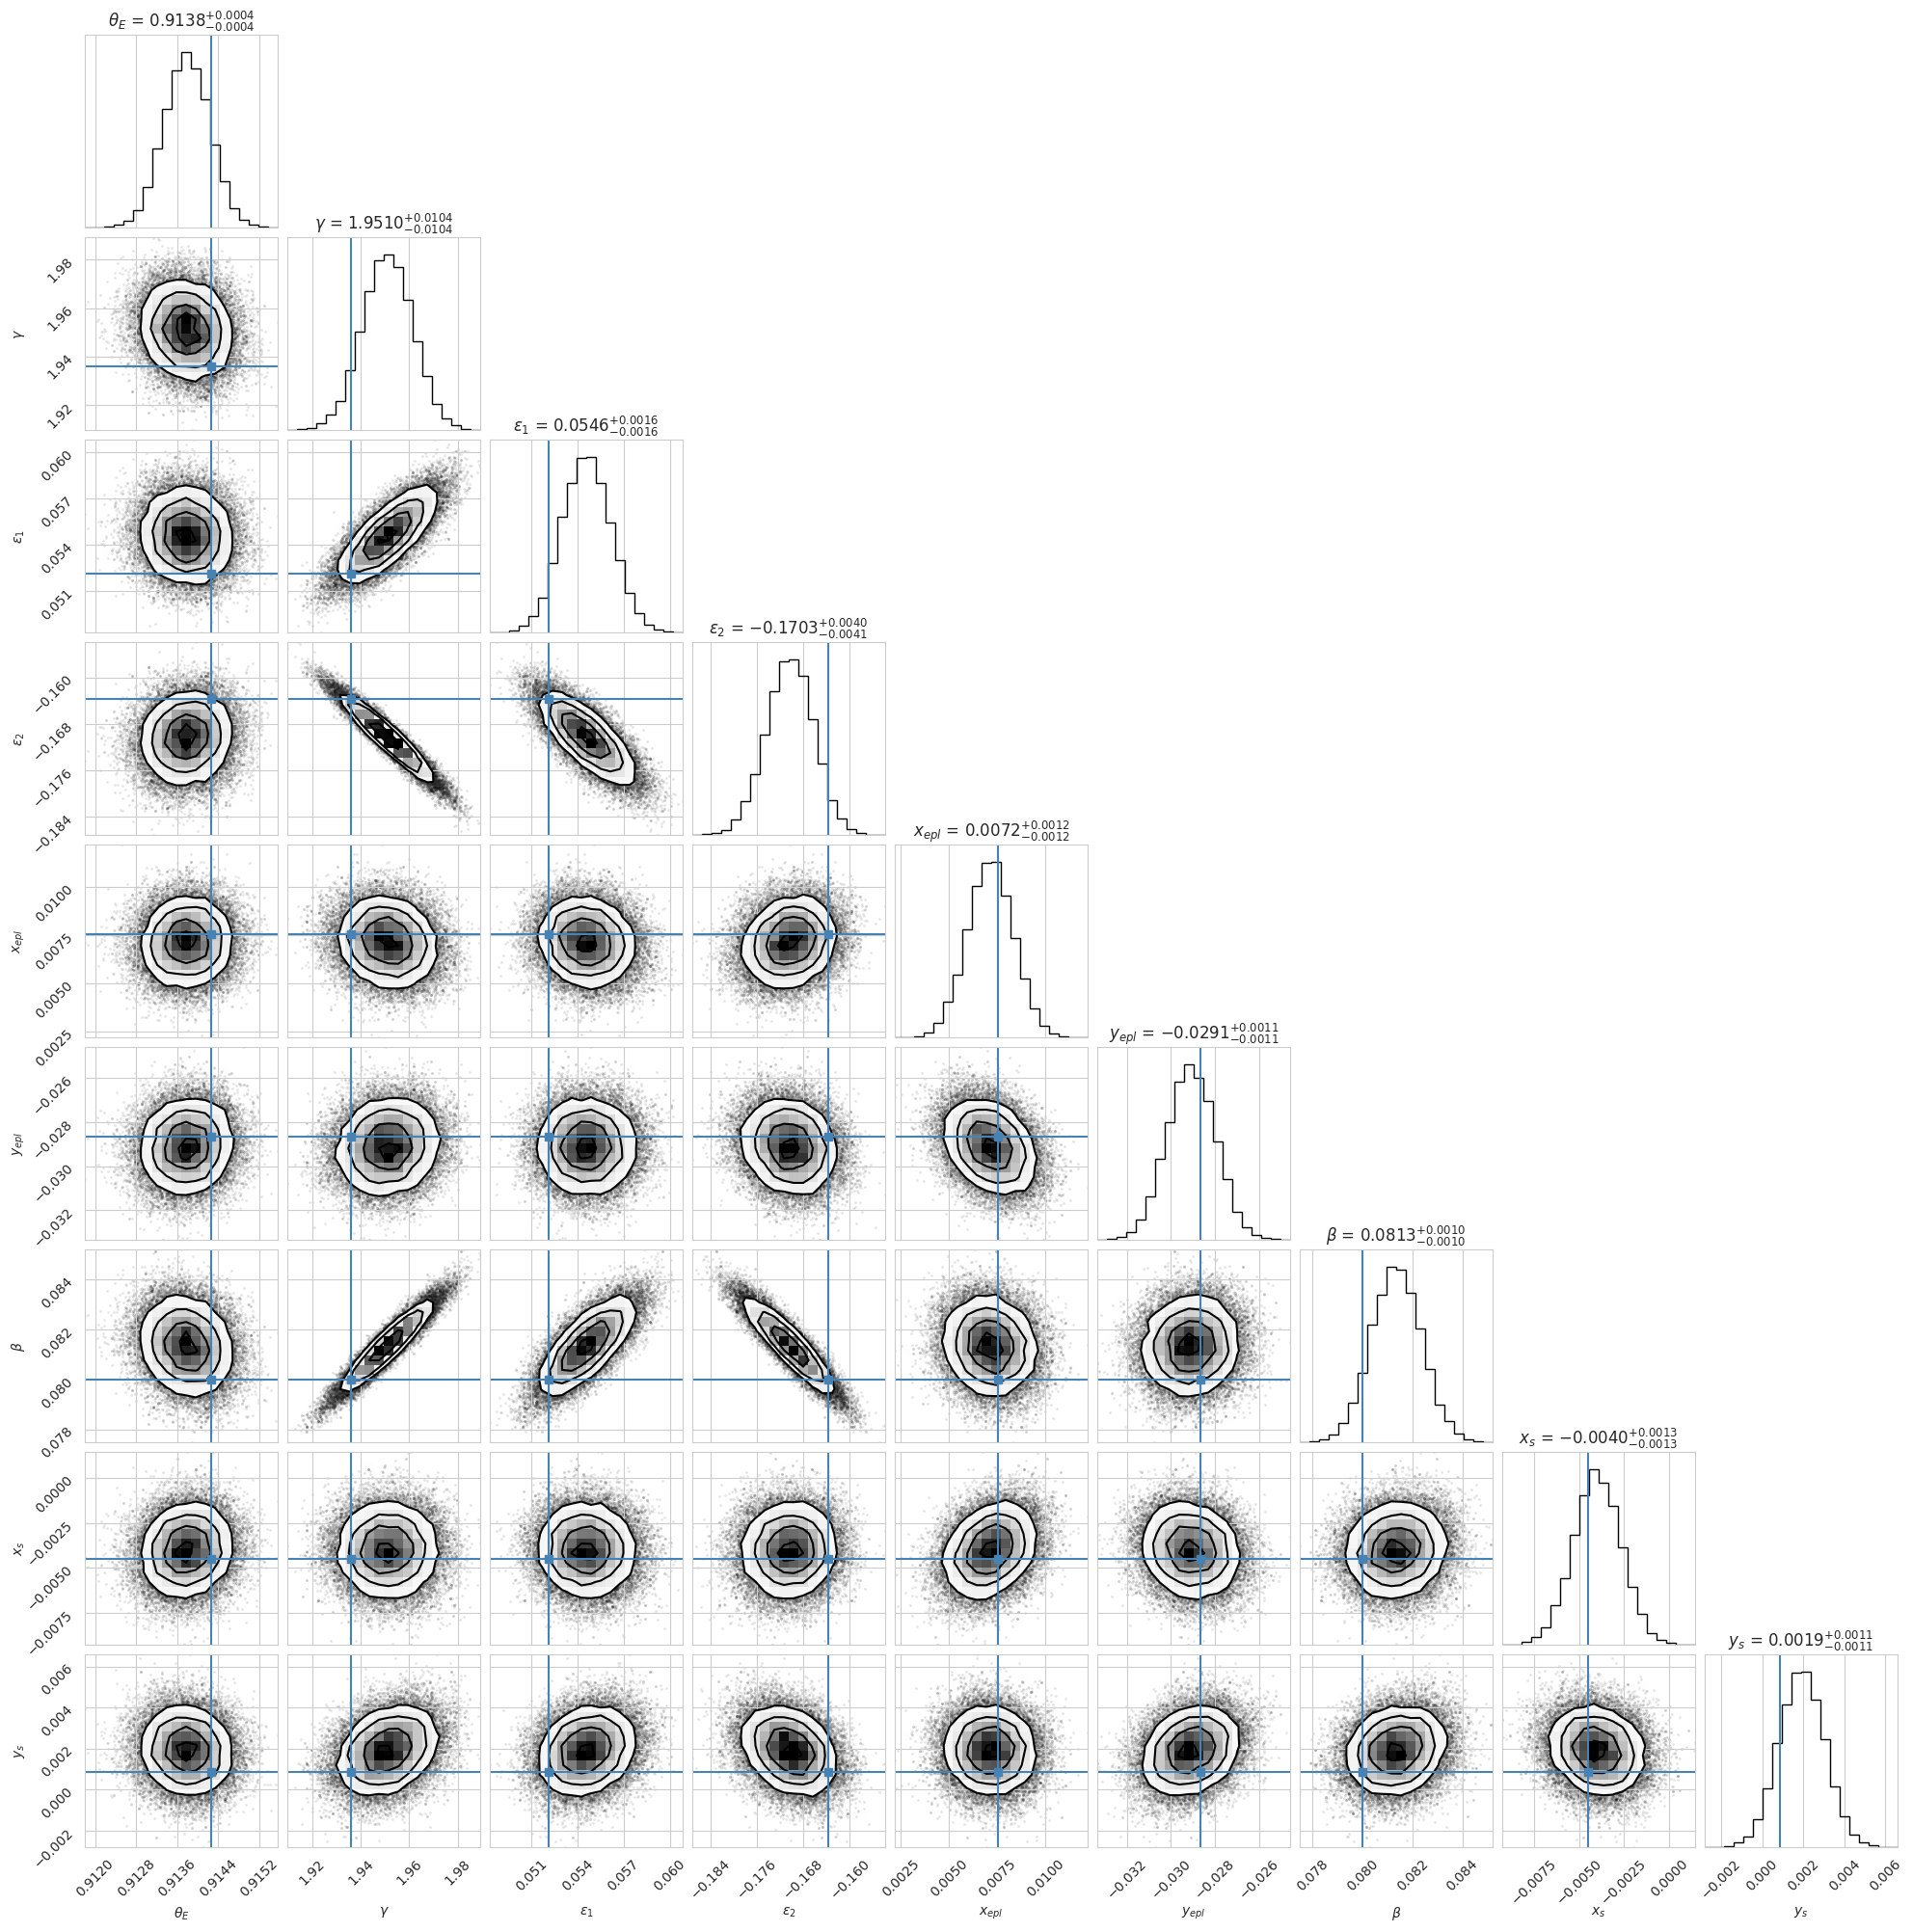

In [15]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[1][0]['beta'],
    x[1][0]['center_x'],
    x[1][0]['center_y'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth).numpy().flatten()
labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x_{epl}$', r'$y_{epl}$', r'$\beta$', r'$x_s$', r'$y_s$']
corner(physical_samples.reshape((len(labels),-1)).T, truths=markers, 
       show_titles=True, title_fmt='.4f',
       labels=labels);

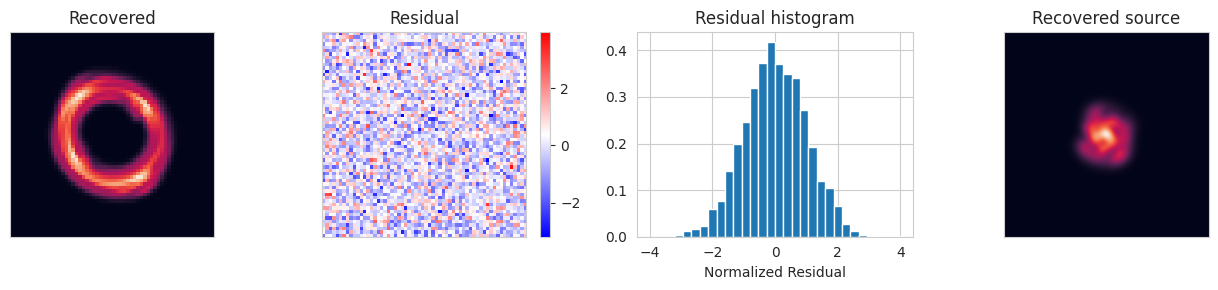

In [16]:
mean_estimate = tf.nest.map_structure(lambda x: tf.reduce_mean(x, axis=(0,1),keepdims=True)[0], prob_model.bij.forward(samples))
plt.figure(figsize=(13,3))
plt.subplot(141)
plt.title('Recovered')
plt.imshow(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))
plt.xticks([])
plt.yticks([])
plt.subplot(142)
plt.title('Residual')
residual = (observed_img-lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))/err_map
plt.imshow(residual, cmap='bwr', interpolation='none')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.title('Residual histogram')
plt.hist(residual.numpy().flatten(), range=(-4,4), density=True, bins=30)
plt.xlabel('Normalized Residual')

coeffs = np.squeeze(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map, return_coeffs=True))
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **mean_estimate[1][0], 
                **{shp._amp_names[i]: tf.convert_to_tensor([coeffs[i]]) for i in range(shp.depth)})
plt.subplot(144)
plt.title('Recovered source')
plt.imshow(np.squeeze(ret))
plt.xticks([])
plt.yticks([])
plt.tight_layout()

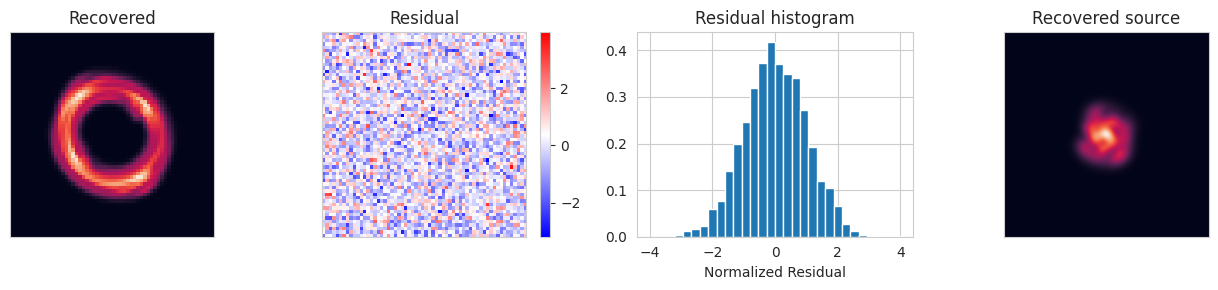

In [17]:
mean_estimate = tf.nest.map_structure(lambda x: tf.reduce_mean(x, axis=(0,1),keepdims=True)[0], prob_model.bij.forward(samples))
plt.figure(figsize=(13,3))
plt.subplot(141)
plt.title('Recovered')
plt.imshow(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))
plt.xticks([])
plt.yticks([])
plt.subplot(142)
plt.title('Residual')
residual = (observed_img-lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))/err_map
plt.imshow(residual, cmap='bwr', interpolation='none')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.title('Residual histogram')
plt.hist(residual.numpy().flatten(), range=(-4,4), density=True, bins=30)
plt.xlabel('Normalized Residual')

coeffs = np.squeeze(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map, return_coeffs=True))
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **mean_estimate[1][0], 
                **{shp._amp_names[i]: tf.convert_to_tensor([coeffs[i]]) for i in range(shp.depth)})
plt.subplot(144)
plt.title('Recovered source')
plt.imshow(np.squeeze(ret))
plt.xticks([])
plt.yticks([])
plt.tight_layout()